#  Clauser-Horne-Shimony-Holt (CHSH) inequality

_This notebook is an integral part of the paper [Bell inequalities wih Qibo](), where the popular inequalities concerning quantum Bell states are presented for educational purposes._

In the third of the series, we instantiate a quantum circuit with Qibo to study the violation of the CHSH inequality proposed in 1969, which can be written introducing the quantity $Q^S$ (cf. paper):

$$Q^S = C(\hat a, \hat c) - C(\hat a, \hat d) + C(\hat b, \hat c) + C(\hat b, \hat d)$$

Once again a local hidden (LH) variables assumption leads to the inequality:

$$|Q^S_{LH}| \leq 2$$

We will show that in a Qibo quantum circuit the inequality is violated in the case of entangled particles with specific measurement angles.

See also the [first notebook](https://cernbox.cern.ch/s/BfHUcWJeDKIRB3T) (temporary link) for the most basic Bell-Wigner inequality. 

In [3]:
import time
from math import pi
import numpy as np
import qibo
from qibo import Circuit, gates
import matplotlib.pyplot as plt

qibo.set_backend(backend="qibojit")

[Qibo 0.2.7|INFO|2024-06-23 23:03:09]: Using qibojit (numba) backend on /CPU:0


Here we instantiate a circuit with free parameters $\theta$ for the rotations before the measurement. The initial $R_Y$ gates stay with a $\theta = \pi$ rotation in order to convert a $|0\rangle$ initial state to $|1\rangle$ prior to constructing the Bell state.

In [4]:
c = Circuit(2)
c.add(gates.RY(q=0, theta=pi))
c.add(gates.RY(q=1, theta=pi))
c.add(gates.H(0))
c.add(gates.CNOT(q0=0, q1=1))
c.add(gates.RY(q=0, theta=0))
c.add(gates.RY(q=1, theta=0))
c.add(gates.M(0, 1))
print('%s\n' % c.draw())

q0: ─RY─H─o─RY─M─
q1: ─RY───X─RY─M─



Now we define a function to run the simulation for some given values of $\theta_1$ and $\theta_2$. Similarly to the Bell case, the returned value is the _correlation_ $C(q_0, q_1) = \overline{q_0 q_1}$, which is required to compute the $Q^B$ quantity.

We also define a number of parameters for the simulation.

In [11]:
def run_circuit_C(th_1, th_2):
    '''run the simulation for the given choice of theta_1 and theta_2,
       and return the correlation between the two qbits'''
    c.set_parameters([pi, pi, th_1, th_2])
    freqs = c(nshots=nshots).frequencies()
    # return the cross correlation: +1 when q0 = q1, -1 otherwise, averaged over all shots
    return (freqs['00'] + freqs['11'] - freqs['01'] - freqs['10']) / nshots

# parameters for the simulation
ab_steps = 6
ac_steps = 50
nshots = 20000

Now run the simulation, and note the computation time on different hardware backends.

The directions $\hat{b}, \hat{c}, \hat{d}$ are all defined with respect to $\hat{a}$, which corresponds to a direct measure with `theta=0`. Therefore we have:
* $\hat{b}$ corresponds to `theta` = $\theta_{ab}$
* $\hat{c}$ corresponds to `theta` = $\theta_{ac}$
* $\hat{d}$ corresponds to `theta` = $\theta_{ab} + \theta_{ac}$

In [12]:
CHSH1 = {}
CHSH2 = {}
tstart = time.time()
for i_ab in range(ab_steps+1):
    print('Run for theta_ab = %2dpi/%d...' % (i_ab, ab_steps))

    th_ab = pi * i_ab/ab_steps    # theta_ab angles go from 0 to pi inclusive
    CHSH1[i_ab] = []
    CHSH2[i_ab] = []

    for i_ac in range(ac_steps+1):
        th_ac = pi * i_ac/ac_steps    # theta_ac angles go from 0 to pi inclusive
        th_ad = th_ab + th_ac
        C_ac = run_circuit_C(0, th_ac)
        C_ad = run_circuit_C(0, th_ad)
        C_bc = run_circuit_C(th_ab, th_ac)
        C_bd = run_circuit_C(th_ab, th_ad)
        CHSH1[i_ab].append(abs(C_ac - C_ad + C_bc + C_bd))
        CHSH2[i_ab].append(abs(C_ac + C_ad - C_bc + C_bd))

print('Completed in %.1f seconds' % (time.time() - tstart))
# In SWAN, this completes in 78 seconds on a CPU, and 5 seconds on a GPU

Run for theta_ab =  0pi/6...
Run for theta_ab =  1pi/6...
Run for theta_ab =  2pi/6...
Run for theta_ab =  3pi/6...
Run for theta_ab =  4pi/6...
Run for theta_ab =  5pi/6...
Run for theta_ab =  6pi/6...
Completed in 58.2 seconds


## Plots

Here we plot the obtained values of $Q^S$ using multiple parametric lines and common `matplotlib` primitives.

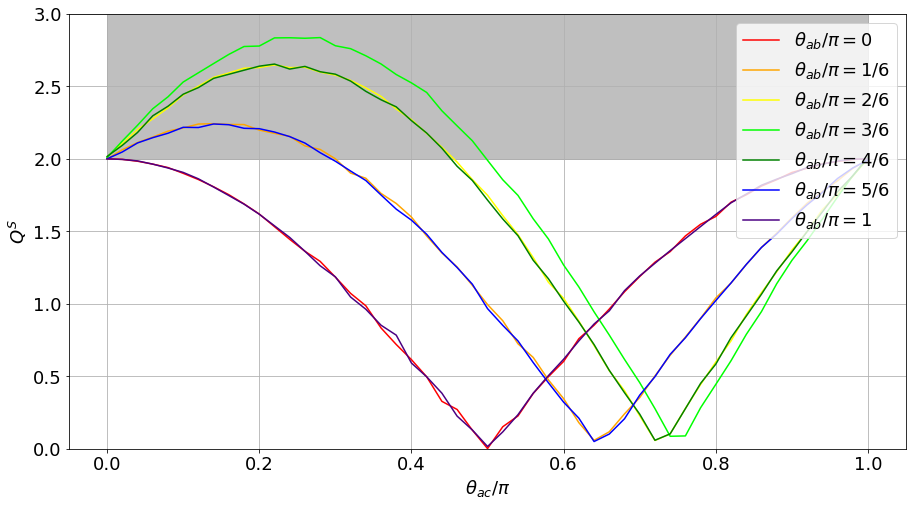

In [19]:
plt.rcParams.update({'font.size': 18})
colors = ["red", "orange", "yellow", "lime", "green", "blue", "indigo"]
fig, ax = plt.subplots(figsize=(15, 8))
th = [(i/ac_steps) for i in range(ac_steps+1)]
labels=['$\\theta_{ab}/\pi = 0$'] + ['$\\theta_{ab}/\pi = %d/%d$' % (i_ab, ab_steps) for i_ab in range(1, ab_steps)] + ['$\\theta_{ab}/\pi = 1$']

for i_ab in range(ab_steps+1):
    ax.plot(th, CHSH1[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])
    #ax.plot(th, CHSH2[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=2, y2=3, color="0.5", alpha=0.5)
ax.set_ylim([0, 3])
plt.xlabel('$\\theta_{ac} / \pi$')
plt.ylabel('$Q^S$')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()
#fig.savefig("simulation_CHSH_Qibo.pdf")

As an additional exercise, we can generate a radial plot, which better illustrates the evolution of $Q^S$ when changing $\theta_{ac}$ from 0, which corresponds to $\hat{c}$ aligned with the $z$ axis that conventionally is represented with the North direction, to $\pi$, which corresponds to $\hat{c}$ pointing to the South direction.

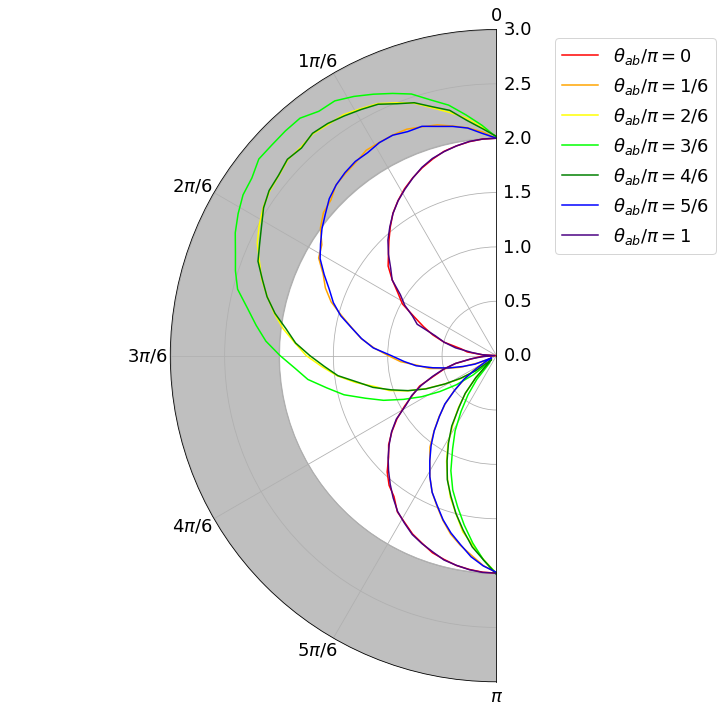

In [20]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
th = [(i*pi/ac_steps) for i in range(ac_steps+1)]

for i_ab in range(ab_steps+1):
    ax.plot(th, CHSH1[i_ab][:len(th)], color=colors[i_ab], label=labels[i_ab])

# color the violation band
ax.fill_between(x=th, y1=2, y2=3, color="0.5", alpha=0.5)

ax.set_xticks([(i*pi/6) for i in range(7)], labels=['0'] + ['$%d\\pi/6$    ' % i for i in range(1, 6)] + ['$\\pi$'])
ax.set_theta_zero_location("N")
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_ylim([0, 3])

#plt.title('Violation of the CHSH inequality')
plt.grid(True)
ax.legend(bbox_to_anchor=(1.1, 1.0))
plt.show()
#fig.savefig("simulation_CHSH_Qibo_polar.pdf")